# Non-Stationary Contextual Bandits Evaluation

In this notebook we will build a simple setting (contextual bandits) to understand how a non-stationary policy should be evaluated. 

#### Contextual bandits
We introduce a contextual bandit with 2 arms, where the choice of its actions $a_t\in\{0,1\}$ also depends on its context $x_t$, which is sampled from a Context distribution $\mathcal{D}$. Since we want a non-stationary contextual bandit, this distribution will change smoothly over time, so the context is sampled from a time-dependend distribution $x_t\sim\mathcal{D}_t$.
Moreover, at each time $t$ the policy parameter will be given by a time-dependent hyperpolicy $\nu$ that is tuned with the hyperparameters $\rho$.

#### Problem definition 
Let's define the non-stationary process that builds the context distributions $\mathcal{D}_t$ as a sinusoidal one, i.e. we have $\mathcal{D}_t = \mathcal{N}(\mu_x(t),\sigma_x)$ with $\mu_x(t) = A_x\sin(\phi_x t + \psi_x) + B_x$ and a constant $\sigma_x$. We want the agent to recognise if $x_t>\mu_x(t)$ (corresponding to $a_t=1$) or if $x_t<\mu_x(t)$ (corresponding to $a_t=0$). The reward is equal to $|x_t-\mu_x(t)|$ if the agent is right and $-|x_t-\mu_x(t)|$ if it is wrong. In order to handle the non-stationary process, the hyperpolicy needs to be based on a similar sinusoidal process, and its goal should be learning and replicating the non-stationary process in order to maximize the rewards.

In the end, the bandit can be represented in two ways, depending on the desired approach:
 - **Action-based exploration**: The stochasticity is given by the policy, which will be represented by a Bernoulli distribution $\pi_{\theta_t}(a_t|x_t) = \left(1-p_t, p_t\right)$, where $p_t \equiv f(\theta_t, x_t) = S(x_t-\theta_t)$ (with $S(x)$ the sigmoid function) and $\theta_t \sim \nu_\rho(\theta_t|t)$. In this case, the hyperpolicy is deterministic and, at each $t$, the value of $\theta_t$ is given by $\theta_t = \nu_\rho(t) = A_\theta\sin(\phi_\theta t + \psi_\theta) + B_\theta$.
 - **Parameter-based exploration**: The stochasticity is given by the hyperpolicy, which is represented by a time-dependent gaussian distribution $\nu_\rho(\theta_t|t) = \mathcal{N}(\mu_\theta(t),\sigma_\theta)$ with $\mu_\theta(t) = A_\theta\sin(\phi_\theta t + \psi_\theta) + B_\theta$ and a constant $\sigma_\theta$. The sampled $\theta_t$ will now define a deterministic policy $\pi_{\theta_t}(x_t)$, which will be represented by a step function centered in $(x_t-\theta_t)$ and will be equal to $1$ if $x_t>\theta_t$ and $0$ if $x_t<\theta_t$.

In [40]:
# Import libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Environment definition

Start by defining the environment that contains the non-stationary context and that assigns rewards for each action of the bandit.

In [41]:
class environment:
    
    def __init__(self, t0=0, sigma_x=1, **kwargs):
        
        # Store the given parameters
        self.t = t0
        self.sigma_x = sigma_x
        
        # if params that define the mean are not given, take random ones
        self.var_names = ['A', 'B', 'phi', 'psi'] 
        for var in self.var_names:
            if var in kwargs.keys():
                setattr(self, var+'_x', kwargs[var])
            else:
                setattr(self, var+'_x', np.random.rand())
    
    
    # Return params of the non-stat environment
    def params(self):
        values = [self.A_x, self.B_x, self.phi_x, self.psi_x]
        return {x:y for x,y in zip(self.var_names, values)}
   
    
    # Compute the context mean in a given istant (or in 'self.t')
    def x_mean(self, t=None):
        if t == None:
            return self.A_x * np.sin(self.phi_x*self.t + self.psi_x) + self.B_x
        else:
            return self.A_x * np.sin(self.phi_x*t + self.psi_x) + self.B_x
    
    # Sample a context from the distibution at time 'self.t'
    def sample_x(self):
        return scipy.stats.norm.rvs(loc   = self.x_mean(), 
                                    scale = self.sigma_x)
    
    
    # Obtain reward of the action 'over_mu': positive if correct
    #                                        negative if wrong
    def get_reward(self, x, over_mu):
        if over_mu == (x > self.x_mean()):
            return np.abs(x-self.x_mean())
        else: 
            return -np.abs(x-self.x_mean())
    
    
    # Use the hyperpolicy nu to perform many subsequent steps
    # Returns the evolution of many variables
    def play(self, nu, n_steps, optimize=False):
        
        contexts = np.array([])
        thetas   = np.array([])
        rewards  = np.array([])
        context_means = np.array([])
        theta_means   = np.array([])
    
        # At each timestep..
        for i in range(n_steps):
            
            # Sample a policy from the hyperpolicy
            policy = nu.sample_policy(self.t)
            
            # Sample a context from the corresponding distribution
            x_t = self.sample_x()
            
            # Perform a step sampling the action from current policy 
            action = policy.action(x_t)
            reward = self.get_reward(x_t, action)
            
            # Optimize hyperpolicy if flag is 'True'
            if optimize:
                
                # DEFINE OPTIMIZATION PROCEDURE
                print('TO DO')
                
                
            # Update time variable
            self.t += 1
            
            # Store current values in the arrays
            contexts = np.append(contexts, x_t)
            thetas   = np.append(thetas, policy.param())
            rewards  = np.append(rewards, reward)
            context_means = np.append(context_means, self.x_mean())
            theta_means   = np.append(theta_means, nu.theta_mean(self.t))

        return contexts, thetas, rewards, context_means, theta_means

## Policy definition

Here we will define the policy class following the structure described at the beginning of the notebook. The action is given by a bool variable (`True` if policy thinks that $x_t>\mu_x(t)$, `False` otherwise). 

If `stochastic = True`, the policy sample the action from the Bernoulli distribution centered in $x_t-\theta_t$, otherwise the policy is just a step function centered in the same quantity.

In [42]:
class policy_class:
    
    def __init__(self, theta, stochastic=True):
        self.theta = theta
        self.stochastic = stochastic
        
    def param(self):
        return self.theta
    
    def bernoulli_distr(self, x):
        p = 1 / (1 + np.exp(-(x-self.theta)))
        return (1-p,p)
       
    def action(self, x):
        if self.stochastic:
            p = 1 / (1 + np.exp(-(x-self.theta)))
            return scipy.stats.bernoulli.rvs(p)
        else:
            return (x > self.theta)

## Hyperpolicy definition

Here we will define the hyperpolicy class following the structure described at the beginning of the notebook. If `param_based = True`, the hyperpolicy will be stochastic and will sample the $\theta_t$ value from the gaussian distribution with a time dependent mean $\mu(t)$, otherwise we just have $\theta_t = \mu(t)$.

In [81]:
class hyperpolicy:
        
    def __init__(self, sigma_theta=1, param_based=True, **kwargs):
             
        # Store the given parameters
        self.sigma_theta = sigma_theta
        self.stochastic = param_based
        
        # if params that define the mean are not given, take random ones        
        self.var_names = ['A', 'B', 'phi', 'psi'] 
        for var in self.var_names:
            if var in kwargs.keys():
                setattr(self, var+'_theta', kwargs[var])
            else:
                setattr(self, var+'_theta', np.random.rand())
               
            
        
    def params(self):
        values = [self.A_theta, self.B_theta, self.phi_theta, self.psi_theta]
        return {x:y for x,y in zip(self.var_names, values)}
    
    
    def theta_mean(self, t):
        return self.A_theta * np.sin(self.phi_theta*t + self.psi_theta) + self.B_theta
        
    def theta_pdf(self, theta, t):
        return scipy.stats.norm.pdf(theta, loc=self.theta_mean(t), scale=self.sigma_theta)
    
    def sample_theta(self, t):
        if self.stochastic:
            return scipy.stats.norm.rvs(loc=self.theta_mean(t), scale=self.sigma_theta)
        else:
            return self.theta_mean(t)
        

    def sample_policy(self, t):
        theta = self.sample_theta(t)
        return policy_class(theta, not(self.stochastic) )
    
    
    #def update_params(self, delta_params):
        
        # TO DO
        

## Test environment

In [132]:
# Get random hyperpolicy
nu  = hyperpolicy(sigma_theta=1, param_based=True,
                  A=5, B=0, phi=0.1, psi=np.pi)

# Initialize environment
env = environment(sigma_x=2, A=5, B=0, phi=0.1, psi=np.pi)

# Play the hyperpolicy
contexts, thetas, rewards, context_means, theta_means = env.play(nu, n_steps=150)

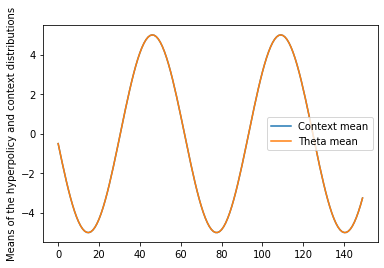

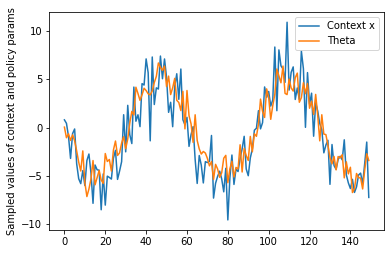

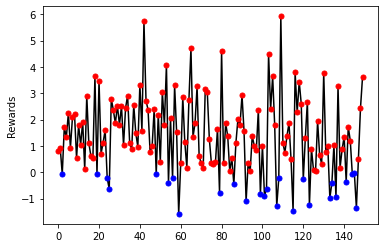

In [133]:
# Plot the evolution of everything
plt.plot(context_means, label="Context mean")
plt.plot(theta_means, label="Theta mean")
plt.ylabel("Means of the hyperpolicy and context distributions")
plt.legend()
plt.show()

plt.plot(contexts, label="Context x")
plt.plot(thetas, label="Theta")
plt.ylabel("Sampled values of context and policy params")
plt.legend()
plt.show()

plt.plot(rewards, c='black')
plt.plot(np.where(rewards>0)[0], rewards[rewards>0], 'ro', markersize=5)
plt.plot(np.where(rewards<0)[0], rewards[rewards<0], 'bo', markersize=5)
plt.ylabel("Rewards")
plt.show()

## Performance estimators
The quantity that we wish to estimate and maximize is the following
$$J=\mathbb{E}_{\nu_\rho(\cdot\vert t+1)} \left[\left. \sum_{i=t+1}^{\infty} \gamma^i R_i \right\vert s_t \right]$$

So, at each timestep, We use the non-stationary policy to estimate the performance of the policy at time $t+1$. We regularize by using importance sampling and, to be specific, we will use MIS-based estimators because the hyperpolicy $\nu_\rho(t)$ changes at each timestep. The "plain" MIS estimator is
$$ \hat{J}=\frac{1}{\alpha}\sum_{i=t-\alpha}^{t}R_i \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)} $$


In [134]:
def MIS_estimator(nu, thetas, rewards, t, return_terms=False):
    
    # Check if rewards and thetas have the same lenght
    if len(thetas) != len(rewards):
        print("\n ----- Thetas and rewards have different lengths ----- \n")
        return None

    # Given present time t, get time of past rewards
    t0 = (t+1) - len(rewards)
    timesteps = np.arange(t0, t+1)
    
    # Compute the weighted rewards inside the time window
    weighted_rewards = np.array([]) 

    for i in timesteps:
        IS_weight = nu.theta_pdf(thetas[i-t0], t+1) / nu.theta_pdf(thetas[i-t0], i)
        IS_reward = rewards[i-t0] * IS_weight / len(rewards)
        weighted_rewards = np.append(weighted_rewards, IS_reward)
    
    # If we are interested in just the estimated performance, don't return the terms
    if return_terms:
        return weighted_rewards
    else:
        return np.sum(weighted_rewards)

### Test Performance Estimator

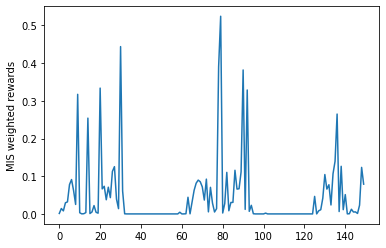

In [135]:
### Study the behaviour of the different terms of the MIS estimator on the last
### timestep using the all the collected rewards and policies (i.e. alpha=t)

# Shift rewards to make them positive (for IS)
shifted_rewards = rewards + 10

# MIS estimator using all the available data
t = len(rewards)
MIS_terms = MIS_estimator(nu, thetas[:], shifted_rewards[:], t, return_terms=True)

# Plot the terms to see how they impact the performance estimation
plt.plot(MIS_terms)
plt.ylabel("MIS weighted rewards")
plt.show()

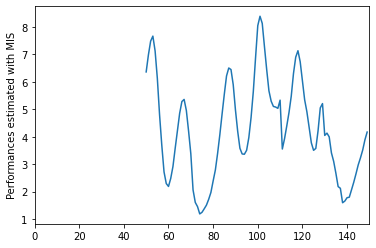

In [138]:
### Test the performance estimators on a sliding window of lenght 50
alpha = 50
performances = np.array([])

shifted_rewards = rewards + 10

# Estimator works only after alpha timesteps and take into account also
# the rewards at time t, thus the right limit for the interval is t+1
for t in range(alpha,len(rewards)):
    J_MIS = MIS_estimator(nu, thetas[t-alpha:t+1], shifted_rewards[t-alpha:t+1], t)
    performances = np.append(performances, J_MIS)
    
# Plot estimated performance
plt.plot(np.arange(alpha,t+1), performances)
plt.xlim(0,150)
plt.ylabel("Performances estimated with MIS")
plt.show()